<a href="https://colab.research.google.com/github/ifigueroa/deep-learning-examples/blob/master/Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised ML Workshop

**- Gouthami Senthamaraikkannan, PhD.
Machine Learning Engineer, Yelp**


## Objective
The objective of this study is to explore the given data from a farming company, extract trends & generate prediction models that can potentially optimize the customer's business.

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd

from itertools import combinations as cmb
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression as LR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR

from matplotlib import pyplot as plt
import seaborn as sns

from importlib import reload
from time import time
from IPython.display import display 

import utils

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Load the dataset
data = pd.read_csv('dataset.csv', index_col=0)
data.sort_index(inplace=True)
display(data.head())
print('The dataset has a total of {} samples'.format(len(data)))

,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
id,,,,,,,,
0,0.072,80.179,9.414,0,29.878,2.231,6,"c,b"
1,5.413,58.359,9.681,2,53.416,1.810,6,"c,b"
2,9.731,78.506,7.189,1,63.391,2.455,1,d
3,10.995,69.248,1.738,3,17.984,0.603,2,a
4,2.617,87.658,9.706,1,49.768,2.910,6,c


The dataset has a total of 1000 samples


A quick view of the data indicates that there is information gathered on 8 different features from across 1000 farms in the country. These are:
- average amount of light and water received per hectare
- types of pesticides used and their amount per hectare
- level of fertilization
- size of farm, specification of region code and 
- total crop yield

Based on this, my first thoughts are that business improvement for the customer could occur through 
- **increase in crop yield** and
- **decrease in operational costs**

Using the other input features, it is possible to train a machine learning regression model to predict & optimize crop yield. But increase in crop yield may be offset by operational costs from increased use of fertilizers, pesticides, water etc. Since we do not know the actual cost factors associated with these, we cannot provide a comprehensive report on the most economically viable model. However using the trained model, we can still inform the customer of the quantitative increase in these utilities for every unit gain of crop yield.

## I. Data Cleaning

The dataset consists of both numerical and categorical variables.

Numerical variables are:
- water - uv - area - amount of pesticides

Categorical variables are:
- level of fertilization - region - categories of pesticides



**Level of fertilization and region are already ordinally encoded by design**. Ordinal encoding is applied when there is a known relationship between classes. While this may be true for level of fertilization (with 0 indicating poor fertility and 5 indicating extreme fertility), **associating increasing integer values with different regions does not seem to make sense**. This has the potential to generate bias in the model. 

Categories of pesticides is present in the dataset as a string representing the combination of pesticides applied to the farm. To encode this, as many one-hot encoded columns are generated, as there are pesticide classes. 

In [ ]:
# converting string to sorted list of pesticide classes
data['categories'] = data['categories'].apply(lambda x: sorted(x.split(',')))

In [ ]:
# pesticide types
pesticide_types = sorted(list(set([c for cc in data['categories'] for c in cc])))
print('There are a total of {} pesticide types applied to the farms: {}'.format(len(pesticide_types), pesticide_types))
# pesticide combinations
pesticide_combinations = Counter([tuple(i) for i in data['categories']])
print('The dataset contains samples with {} pesticide combinations, i.e. all possible combinations'.format(len(pesticide_combinations)))

There are a total of 4 pesticide types applied to the farms: ['a', 'b', 'c', 'd']
The dataset contains samples with 15 pesticide combinations, i.e. all possible combinations


### A. One-Hot Encoding of pesticide combinations

In [ ]:
# Generate a one-hot encoded column for each pesticide class
for p in pesticide_types:
    data['pesticide_{}'.format(''.join(p))] = data['categories'].apply(lambda x: 1 if p in x else 0)
data.drop(['categories'], axis=1, inplace=True)

Looking at the dataset now, there are three types of features present in the dataset. These are:

- One-hot encoded pesticide classes
- Other categorical features: level of fertilizaton, region
- Numerical features: water, uv, area, pesticides

In [ ]:
pesticide_features = [p for p in data.columns if 'pesticide_' in p]
pesticide_labels = [s.replace('pesticide_', '') for s in pesticide_features]

other_categorical_features = ['fertilizer_usage', 'region']
ocatf_labels = ['level of fertilization', 'region']

numerical_features = ['water','uv', 'area', 'pesticides']
numf_labels = ['water per hectare', 'uv per hectare', 'farm size', 'amount of pesticides']

target = ['yield']

data.head()

,water,uv,area,fertilizer_usage,yield,pesticides,region,pesticide_a,pesticide_b,pesticide_c,pesticide_d
id,,,,,,,,,,,
0,0.072,80.179,9.414,0,29.878,2.231,6,0,1,1,0
1,5.413,58.359,9.681,2,53.416,1.810,6,0,1,1,0
2,9.731,78.506,7.189,1,63.391,2.455,1,0,0,0,1
3,10.995,69.248,1.738,3,17.984,0.603,2,1,0,0,0
4,2.617,87.658,9.706,1,49.768,2.910,6,0,0,1,0


Thus there are **totally 10 feature columns**. The **target** variable is the **total crop yield**. 

Using these input features, we can train several regression models to predict the target. Based on a suitable metric, top performing models can be chosen. Some of these models can generate feature importances. When this is available, it would be possible to quantify the effect of each feature on the total crop yield. This knowledge would in turn be very useful to guide the client's operational decisions for maximizing his/her profit. 

### B. Treating missing values

The next step is to find missing values in the dataset and either drop them or perform imputation through suitable strategies.

In [ ]:
ctdf = data[numerical_features].describe().loc[['count']].apply(lambda x: 100.00*(1 - x/len(data)))
ctdf.index = ['% missing values']
display(ctdf)

,water,uv,area,pesticides
% missing values,4.2,5.1,0.0,0.0


As can be seen, only the features - water and light received per hectare have some missing values. Specifically, 

In [ ]:
missing_water_uv = len(data.dropna())
missing_water = len(data['water'].dropna())
print('Number of samples with missing values for water & light received per hectare is {}'.format(missing_water_uv))
print('Number of samples with missing values for water received per hectare is {}'.format(missing_water))

Number of samples with missing values for water & light received per hectare is 911
Number of samples with missing values for water received per hectare is 958


**By dropping all the missing values, we can lose upto 10% of the data. The other choice is imputation.** To do this, we need to get an idea of the feature statistics for water & light. 

In [ ]:
data[['water', 'uv']].describe().apply(lambda x: round(x, 1)).T

,count,mean,std,min,25%,50%,75%,max
water,958.0,12.2,172.3,0.1,4.6,6.5,8.8,5340.0
uv,949.0,74.0,9.9,45.3,66.5,73.7,80.6,106.3


Based on the statistics above:
- **'Light received'** seems to have a small standard deviation and equally spaced quantiles. Thus, we can approximate the values to come from a standard distribution and perform imputation by simply **replacing missing values with the column mean.**


- **'water received'** on the other hand seems to have equally spaced 25%, 50% and 75% quantiles. The max value is however completely out of range. Assuming that the large values are not errors of data collection, it might be better to **drop them instead of imputing.**

#### Imputing uv feature

In [ ]:
# Impute missing uv values
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
data['uv'] = imp.fit_transform(data['uv'].values.reshape(-1, 1))

# Drop missing water values
data.dropna(inplace=True)
data.reset_index(inplace=True)
print('The dataset size is now {}'.format(len(data)))

The dataset size is now 958


## II. Exploratory data analysis, feature transformations

Having completed the initial data cleaning steps, we proceed to a few exploratory analyses. 

Most regression models underperform when the underlying features have **skewed distributions**. To avoid this, we check the distributions of the input features and perform **transformations** when necessary. 

### A. Distribution of numerical & other categorical features

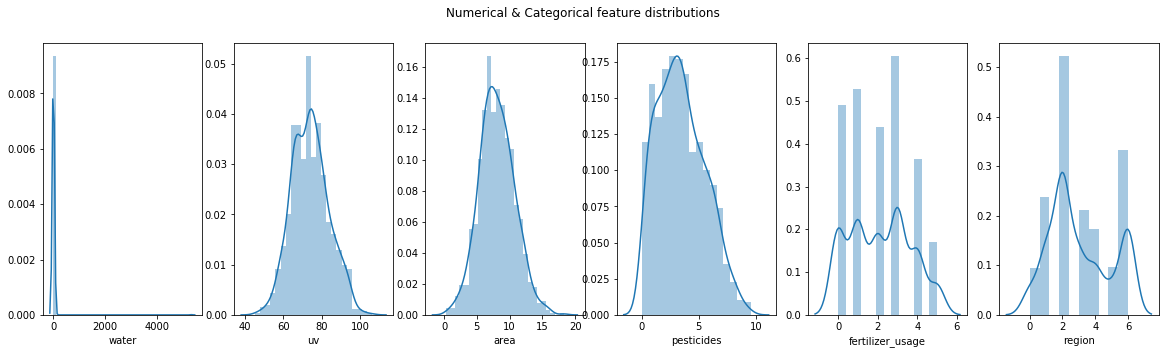

In [ ]:
utils.plot_feature_distribution(data, numerical_features + other_categorical_features, numf_labels + ocatf_labels,\
                             figtitle='Numerical & Categorical feature distributions')

- "water received per hectare" is extremely skewed and amount of pesticides is quite skewed too. Therefore we apply Box Cox transformations to these variables to make them approximately normal.
- level of fertilization and region variables are not continuous, their distributions are also not smooth. Except for fertilization level 5, all other levels are almost uniformly distributed in the dataset. Region classes are however relatively widespread in the dataset


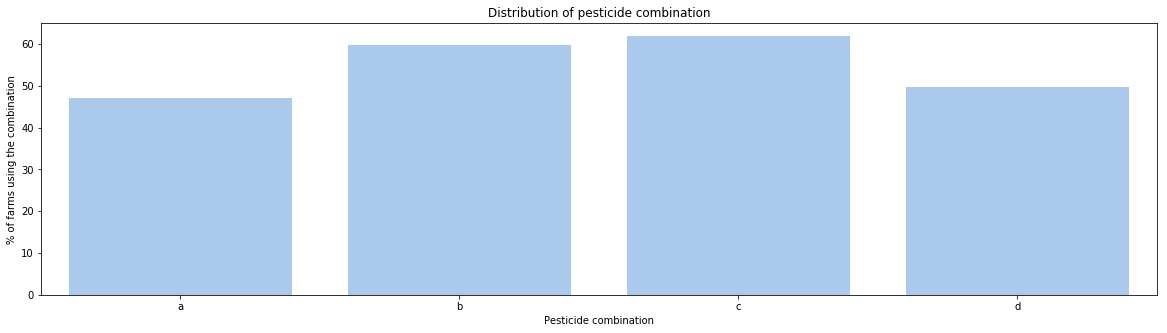

In [ ]:
utils.plot_feature_distribution(data, pesticide_features, pesticide_labels, features_type='pest')

The different pesticide combinations used in farms are almost uniformly distributed in the range of ~ 50 to 60%

### B. Feature transformations

In [ ]:
# Applying Box Cox transformation to water, pesticides
data['water'] = stats.boxcox(data['water'])[0]
data['pesticides'] = stats.boxcox(data['pesticides'])[0]
print('The transformed "water" variable is now approximately normally distributed.')

The transformed "water" variable is now approximately normally distributed.


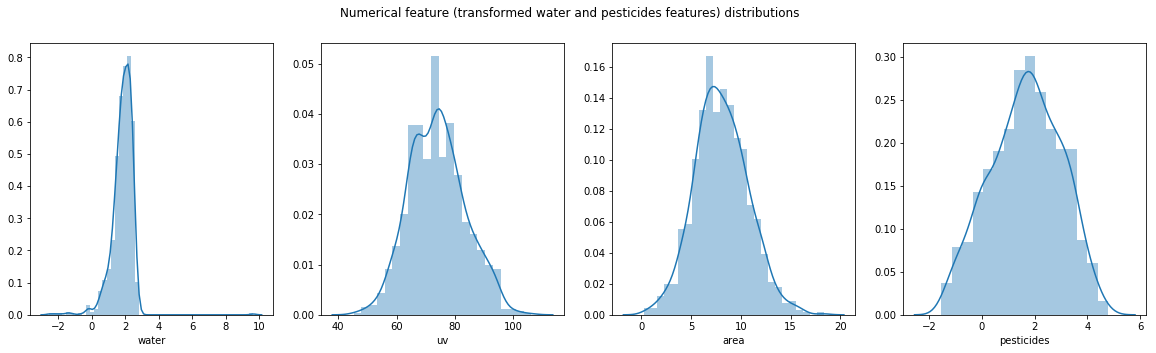

In [ ]:
utils.plot_feature_distribution(data, numerical_features, numf_labels, figtitle='Numerical feature (transformed water and pesticides features) distributions')

## C. Target Distribution

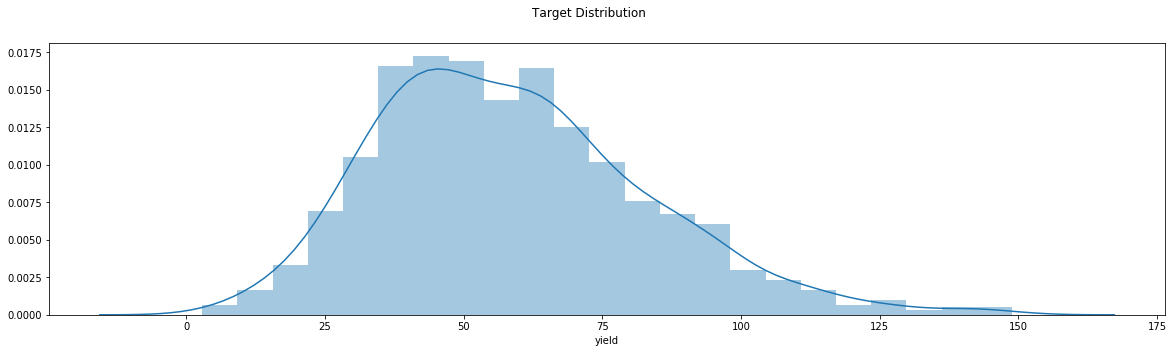

In [ ]:
utils.plot_feature_distribution(data, ['yield'], ['yield'], figtitle='Target Distribution')

Looking at the target distribution, we see that it is slightly skewed. This poses a problem since a Gaussian outcome is representative of independent instances, which will allow us to train more generalized models. Further, since the model predicts crop yield, it is required that it only outputs positive values. To achieve these two, we apply a **square root transformation to the outcome**. The transformation approximates the distribution to a Gaussian and the predicted value of crop yield is the square of the model outcome, i.e., a positive number always. 

In [ ]:
data['yield'] = data['yield'].apply(lambda x: np.sqrt(x))

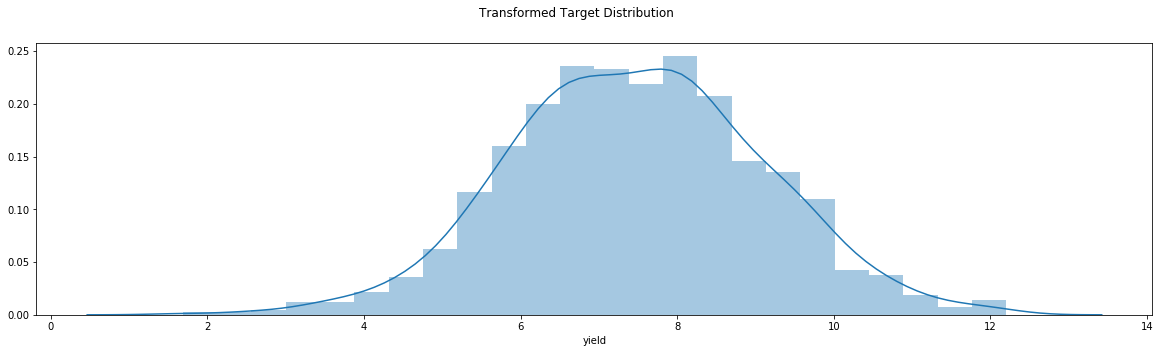

In [ ]:
utils.plot_feature_distribution(data, ['yield'], ['yield'], figtitle='Transformed Target Distribution')

### C. Feature scaling

The features & target are now transformed to approximately standard distributions. The next step is to scale them so that the model is able to treat them all equally. Scalers that are typically used are standard scaler and minmax scaler. Each of these **scalers are first trained on the data to obtain the relevant statistics.**

**Ideally this is done after splitting data to train & test fractions. This way we can ensure that test data is fully unseen.** 

However in this case, by **assuming that the feature statistics will not vary much on including the test fraction**, we go ahead with applying scalers before splitting the data.

#### Applying standard scalers to numerical features

In [ ]:
stdsc = StandardScaler()
data[numerical_features] = stdsc.fit_transform(data[numerical_features].values)

#### Applying minmax scalers to other categorical features

In [ ]:
mmsc = StandardScaler()
data[other_categorical_features] = mmsc.fit_transform(data[other_categorical_features].values)

#### Applying standard scaler to target

In [ ]:
targetsc = StandardScaler()
data[target] = targetsc.fit_transform(data[target].values)

### D. Feature correlation heatmap

Now that we have applied the necessary transformations to the dataset, we plot a heatmap to observe the correlations amongst the feature and target variables.

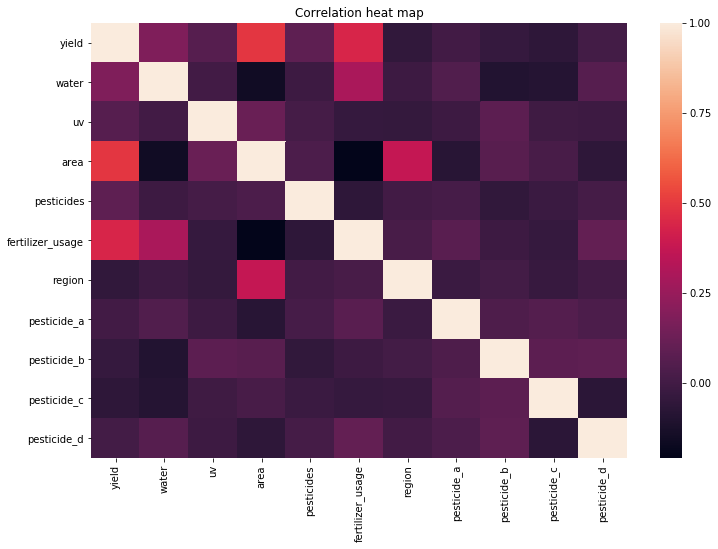

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(data[target + numerical_features + other_categorical_features+ pesticide_features].corr(), ax=ax)
ax.set_title('Correlation heat map')
plt.show()

As can be seen from the heatmap:

- **yield is highly correlated with area, level of fertilization, followed by water and amount of pesticides**. This makes a lot of sense. However, yield has low correlation with region.


- **Feature pairs with high correlation are:**
    1. water & level of fertilization
    2. area & region
    3. area & uv


- **Feature pairs with no correlation are:**
    1. area & water
    2. area & level of fertilization
    
    
- Varying levels of correlation exist between pesticide combinations and other features as well as the target (yield).

The above indicates that while we may have a good feature set for predicting the target, the features themselves are correlated. **This issue of feature correlation will lead to unstable solutions in regression algorithms**. Therefore **prediction results may well improve if we apply feature reduction techniques** before training the models. 

### E. Feature reduction

In [ ]:
features = numerical_features + other_categorical_features + pesticide_features
X = data[features]

PCA is an unsupervised learning method that will help us to reduce the dimensionality of the features by projecting the data onto fewer principal components. **Ideally this also needs to be done only on the training fraction of the data**. But as mentioned above, we assume that adding the test data points to the feature set will not alter the covariance too much. 

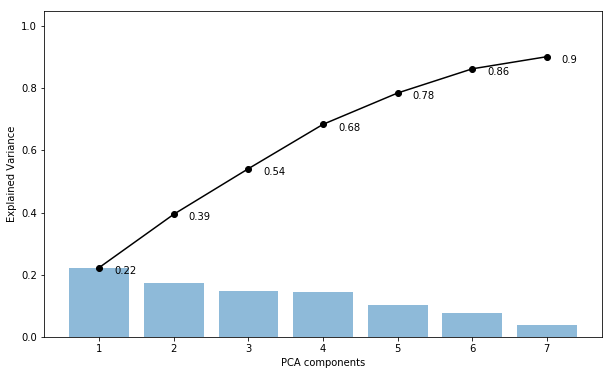

In [ ]:
pca = PCA(n_components=0.90)
pca.fit(X[features])
utils.plot_pca_variance(pca)

The plot above indicates that 90% of the total variance in data is explained with 7 principal components. 

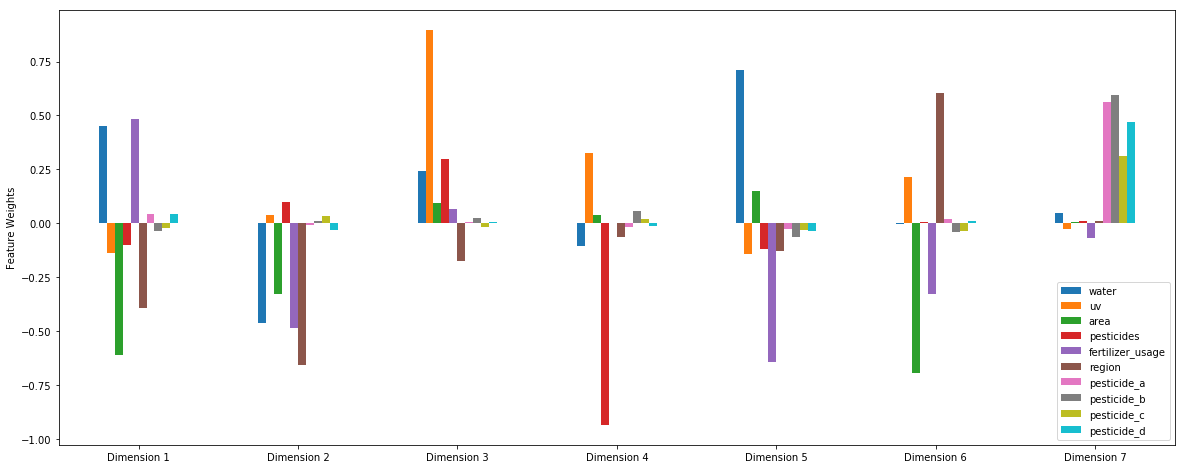

In [ ]:
utils.visualize_pca_results(X, pca)

Summary of above visualization:

- water, area, level of fertilization and region are the highes contributing features to both PC1 and PC2. (exactly in agreement with what we observed with the heat map)


- PC3 is dominated by uv and PC4 by amount of pesticides


- pesticide classes only start cropping up at around dimension 7, by which point more than 85% of variance in data has already been captured. This also indicates again that pesticide classes are not really important features to determine crop yield


In [ ]:
X_reduced = utils.return_reduced_data(X, pca)

## III. Modeling: training, selection by evaluation

First we need to split the data to train and test fractions.

### A. Splitting data

For model evaluation I chose test size to be 25%.

In [ ]:
Y = data[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
X_red_train, X_red_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size = 0.25, random_state = 0)

In `utils.py`, I have created a pipeline that will train regression models and store the respective metrics evaluated on train/test fractions. I am choosing the following 3 models.

1. Simple linear regressor - This is a simple model and should therefore be the first choice since the simpler the model, the greater its generalizing ability


2. Support Vector Regressor - SVR determines a regressor hyperplane using only support vectors. Not only does it give options for nonlinear kernels, it also has hyperparameters that will prevent us from overfitting to the training data


3. Gradient boosting Regressor - GBR works by training a weak decision tree on a subset of features, and subsequent trees fitted on the negative gradient of the given loss function. It is expected to overcome overfitting present in decision trees (which are by design low bias high variance models)

The metrics I chose for evaluation are:
1. mean squared error (MSE)
2. Coefficient of determination ($R^2$) - This is a measure of the quality of fit. We hope to get as close to 1

### B. Training & Evaluating models on dataset

Using the pipeline the 3 models are trained and the train/test metrics are computed.

**NOTE: the mse/r2 metrics are computed on the transformed/scaled output variable**

LinearRegression trained on 718 samples
SVR trained on 718 samples
GradientBoostingRegressor trained on 718 samples

Best regressor is GBR
            mse        r2
train  0.046708  0.953061
test   0.100720  0.900684


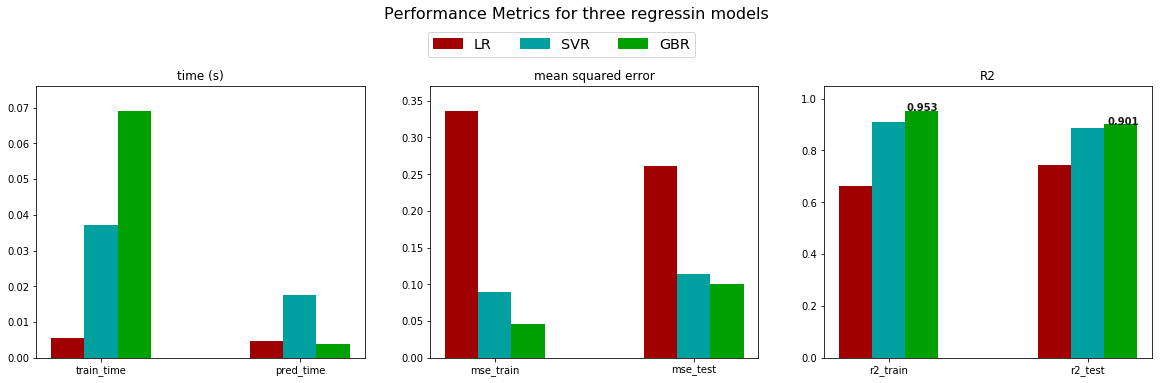

In [ ]:
# Calling LR, SVR, GBR for training, results stored in dict
results = utils.train_predict(['LR', 'SVR', 'GBR'], X_train, Y_train, X_test, Y_test)
utils.evaluate(results)

As seen from the plots, GBR is the best model with maximum performance. However, 
- it takes more time for training. 
- there are signs of overfitting, since train $R^2$ is much higher than test $R^2$.

### C. Training & Evaluating models on reduced dataset

We now train and evaluate the models on a reduced feature space (PCA transformed to account for 90% of variance in the data)

LinearRegression trained on 718 samples
SVR trained on 718 samples
GradientBoostingRegressor trained on 718 samples

Best regressor is SVR
            mse        r2
train  0.090662  0.908888
test   0.117330  0.884305


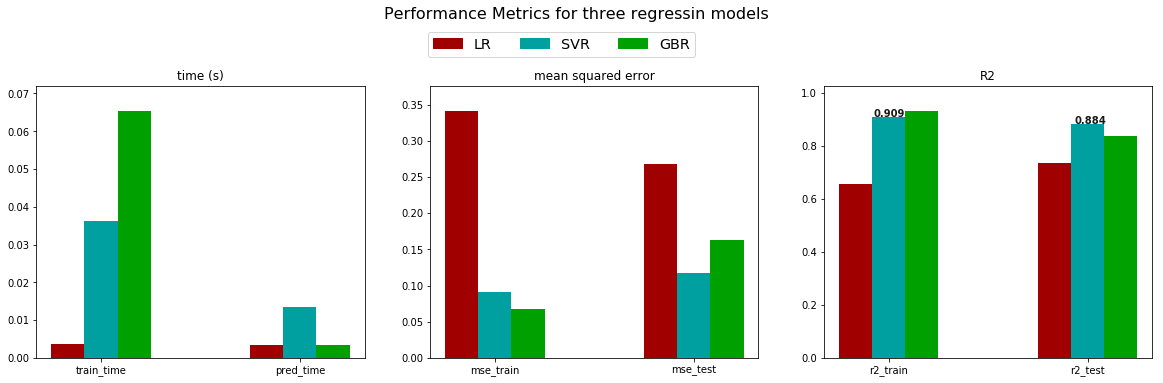

In [ ]:
results = utils.train_predict(['LR', 'SVR', 'GBR'], X_red_train, Y_train, X_red_test, Y_test)
utils.evaluate(results)

Here, SVR performance exceeded that of GBR. The $R^2$ scores are lower than what was observed from training the model on the complete feature space. **But there are no worrying signs of overfitting. So it appears to be a model than can be trusted more.**

Now that we have selected the best models, we perform hyperparameter tuning to further improve the model scores.

## IV. Hyperparameter tuning

- The following are **results of grid search experiments for tuning hyperparameters** of the models chosen above.


- **Each experiment was conducted with 3 cross validation folds**. (metrics used to determine best model are average of scores from each CV fold)


- First we look for the best set of hyperparameters of the GBR model trained on the complete feature space.


- **NOTE: In the following results, mse/r2 are computed on the transformed/scaled output. Comparison plots are however plotted after applying inverse transformations to the predictions**

### A. Best GBR model (complete feature space)

            mse        r2  mse_Optimized  r2_Optimized
train  0.046708  0.953061       0.018674      0.981233
test   0.101853  0.899567       0.088325      0.899567
Total time taken : 37 seconds


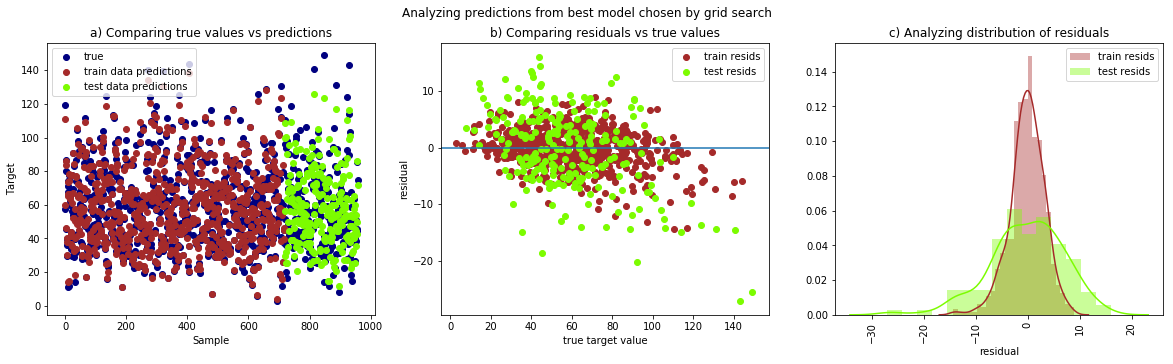

In [ ]:
# search for best model using all features
reg = GBR(random_state=0)
parameters = {'learning_rate':[0.05, 0.01, 0.001], 'n_estimators': [50, 100, 500],\
              'subsample': [1.0, 0.85, 0.7], 'max_depth': [3, 5]}
start = time()
grid_fit, best_reg = utils.optimize_hyperparameters(reg, parameters, X_train, X_test, Y_train, Y_test)
print('Total time taken : {} seconds'.format(round(time() - start), 2))

train_pred = best_reg.predict(X_train)
test_pred = best_reg.predict(X_test)
utils.compare_predictions(targetsc, Y_train, Y_test, train_pred, test_pred)

The grid search returned a GBR with 0.018 MSE on train data and 0.088 MSE on test data. While this is an improvement from unoptimized model, the metrics are quite **clearly reeking of overfitting.** The plots analyzing the residuals further suggests this. As seen in figure b), the residuals are not randomly distributed around 0. And figure c) indicates that the training residuals are lying more tightly around 0 than testing residuals, which implies overfitting.

Now, we search for the best model using PCA transformed reduced feature set

### B. Best SVR model (reduced feature space)

            mse        r2  mse_Optimized  r2_Optimized
train  0.090662  0.908888       0.071722      0.927923
test   0.117330  0.884305       0.110062      0.884305
Total time taken : 2 seconds


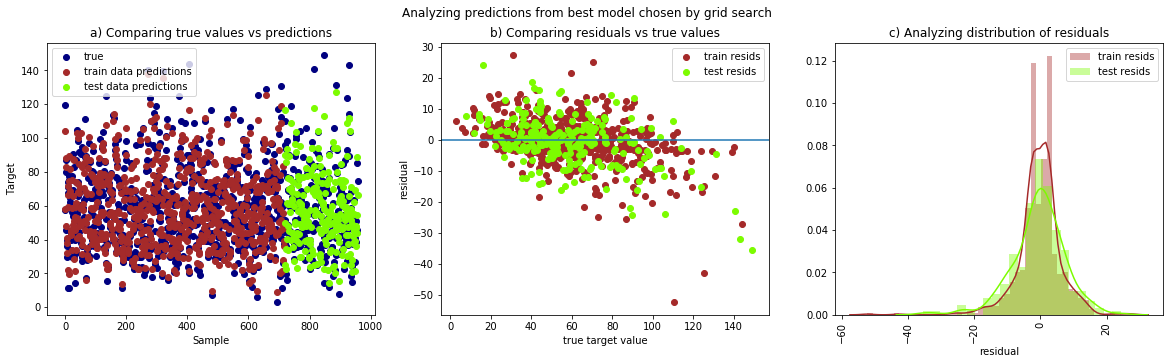

In [ ]:
# search for best model using reduced feature space
reg_red = SVR()
parameters = {'C': [0.1, 1, 1.5, 2], 'degree': [2,3,4,5]}
start = time()
grid_fit, best_reg_red = utils.optimize_hyperparameters(reg_red, parameters, X_red_train, X_red_test, Y_train, Y_test)
print('Total time taken : {} seconds'.format(round(time() - start), 2))

train_pred = best_reg_red.predict(X_red_train)
test_pred = best_reg_red.predict(X_red_test)
utils.compare_predictions(targetsc, Y_train, Y_test, train_pred, test_pred)

This grid search returned an SVR with 0.071 MSE on train data and 0.11 MSE on test data (an improvement on the unoptimized model). Although the error on test data is higher than what was obtained with the GBR, figure c) indicates that the distributions of train and test residuals are closer in this case. So overfitting is not an issue here. Figure b) however shows that the residuals are still **not randomly distributed around 0, which indicates bias.**

Thus, the conclusion is that the 

- **GBR model, using the complete feature space** produces better metrics but strongly indicates overfitting which reduces the trust in it. In other words, it faces an issue of **low bias, high variance.**  


- Whereas the **SVR model, using reduced feature space** produces a more generalized model that has higher error. In other words, it faces an issue of **high bias, low variance.**

## V. Feature Importances

Before we proceed to other methods for model improvement, using the best fit GBR model, importances of the input features are analyzed.

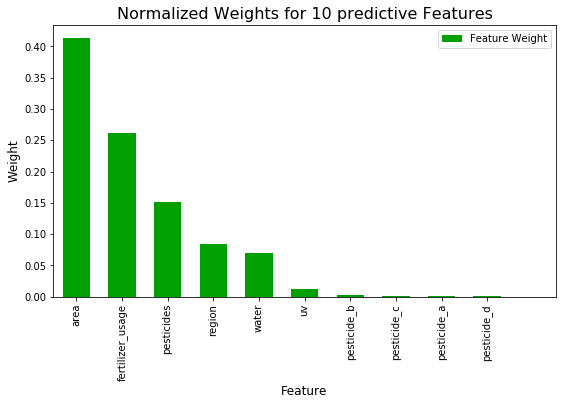

In [ ]:
weights = best_reg.feature_importances_
utils.feature_plot(weights, X_train, n=10)

The plot above indicates that 

- area, which has highest correlation with yield has the highest weightage in the GBR


- ferlization level and amount of pesticides are also highly ranked


- surprisingly, **region which had no correlation with yield is weighed higher than water. This is a clear indicator that the relationship between yield and region is highly nonlinear. Ordinal encoding of this variable may also be a contributing factor to this effect**, as described in the beginning of this study.

**Coming back to prediction models, we saw that neither models performed well enough to be accepted. For improvement, I am now resorting to feed forward neural networks (built in keras)**

## VI. Model improvement: feedforward neural networks for regression

Through some trial and error, I found that the following neural architecture performed well on the given dataset. 

- Dense Layer 1 - 100 neurons, activation - tanh
- Dense Layer 2 - 50 neurons, activation - tanh
- Dense Layer 3 - 1 neuron, activation - linear (final output)

I used an adam optimizer with learning_rate = 0.001 and epochs = 100

**Since the PCA transformed reduced feature space have non correlated features, I am using the reduced data (X_reduced) to train the model. Moreover, total training time is shorter with reduced feature space.**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
_________________________________________________________________
            mse        r2
train  0.078202  0.921410
test   0.110346  0.891192


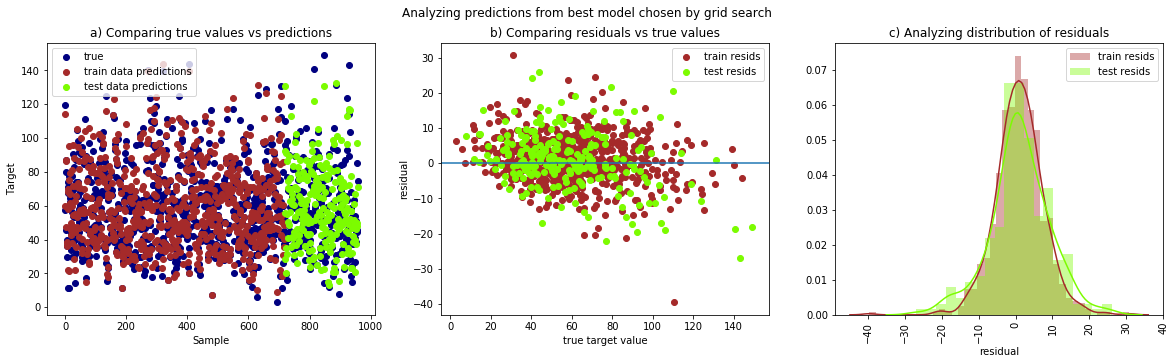

In [ ]:
reload(utils)
model, results = utils.train_predict_neural_net(X_red_train, X_red_test, Y_train, Y_test)
print(results)

train_pred = model.predict(X_red_train)
test_pred = model.predict(X_red_test)
utils.compare_predictions(targetsc, Y_train, Y_test, train_pred, test_pred)

The results show that the **error on test fraction has not improved from what we already had, at 0.11.**

Figure c) however shows **statistically similar normal distributions of the residuals** in both the train and test fractions. This is an excellent indicator that there is **no overfitting.**

Also, figure b) indicates more **randomness in the distribution of residuals around 0** than we have observed so far, ie., no clear trend is evident. This implies **low bias** in the model as well. 

## VII. Conclusion

- Data cleaning & preprocessing steps included one-hot encoding of pesticide classes, treatment of missing values, transformations of skewed distributions and scaling, normalization. 


- To remove feature dependencies, the feature space was projected on principal components using **PCA**. Model training & evaluation were conducted both with complete and reduced feature spaces.


- **Data scaling** as well as **PCA** transformation were **performed on the entire dataset (i.e., both training & testing fractions).** Although this is not ideal, I went ahead with it under the assumption that the feature distributions do not vary too much before and after dropping the test fraction.


- At the end of the study, a suitable regression model was trained to predict crop yield. This is a **3 layer neural network model trained on PCA transformed, reduced feature space.** Reduced feature space motivates stabler models. Although training time isn't particularly an issue here, the reduced feature space further curbs this time.


- **Classical** machine learning models such as SVR and GBR had **limitations of high bias and high variance** respectively. 


- **Grid search** experiments were conducted on **3 cross validation folds** to find the best set of hyperparameters. The **neural network was however not trained on cross validation folds.** Including this will further improve the robustness and generalizability of the prediction model.


- Feature importances derived from the GBR model indicates that area, fertilization level, pesticides, region, water and uv are the features with highest weightages in that order. While most of this is in agreement with the feature correlation plots, the **region variable alone stands as a discrepancy (possibly due to nonlinear relationship with yield or due to effects of ordinal encoding in the absence of known interrelationship between classes)**

## VIII. Next steps

Based on the study so far, I believe that the following next steps are important to this project:

- Separate the data to train and test fractions and only use the train fractions for fitting scalers and PCA objects. This is to **ensure that the test data is truly unseen.**


- **Establish cross validation frameworks** for training & evaluation of all models including the feed forward neural networks.


- **Establish complete/partial grid search experiments or other hyperparameter search algorithms** (eg. Bayesian optimization) to optimize the neural networks and improve scores on unseen data. 


- Understand more about interrelationships between features & with the target for guidance on **feature selection**. 


- Investigate the region variable further, possibly get more domain knowledge on it to understand why/how it would be related to the yield. **Experiment with embeddings to encode the classes in fertilization level and region variables.** Embeddings can bring out better representations of the classes, which can potentially improve model performances.